In [56]:
#importing necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords



# model building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from tensorflow.keras.preprocessing.text import Tokenizer

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hunchoahmad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hunchoahmad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
#read and understand the data
train = pd.read_csv("/Users/hunchoahmad/Downloads/Corona_NLP_train.csv", encoding="latin-1") 
test = pd.read_csv("/Users/hunchoahmad/Downloads/Corona_NLP_test.csv", encoding="latin-1")
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [58]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [59]:
print(train.info(),'\n')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage:

In [60]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

In [61]:
train.drop(['UserName', 'ScreenName'], axis=1, inplace=True)
test.drop(['UserName', 'ScreenName'], axis=1, inplace=True)

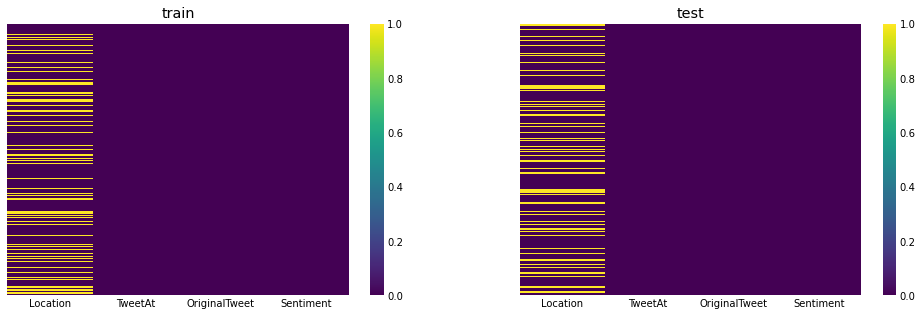

In [62]:
# we are shwoing columns with missing values
plt.figure(figsize=(15,5))
for index, df in enumerate([train, test]):
    plt.subplot(1,2, index+1)
    sns.heatmap(df.isnull(), cmap='viridis', yticklabels= False).set_title('train' if index==0 else 'test')

plt.show()
#only location column has missing values

In [63]:
# checking the number of missing values
print(train.isnull().sum())

Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [64]:
# check Location
print(train.Location.value_counts(normalize= True, dropna= False)[:30] *100)

NaN                        20.871298
London                      1.312049
United States               1.282892
London, England             1.263455
New York, NY                0.959740
Washington, DC              0.906286
United Kingdom              0.818816
Los Angeles, CA             0.682751
India                       0.651165
UK                          0.563695
Australia                   0.546687
USA                         0.541828
Canada                      0.464077
England, United Kingdom     0.464077
Toronto, Ontario            0.388755
Global                      0.386326
Chicago, IL                 0.376607
California, USA             0.371747
San Francisco, CA           0.369317
Boston, MA                  0.364458
New York, USA               0.340161
New Delhi, India            0.335301
Atlanta, GA                 0.306145
New York                    0.306145
Mumbai, India               0.264840
Worldwide                   0.245402
Lagos, Nigeria              0.240542
H

In [65]:
train.Location = train.Location.str.split(',').str[0]

In [66]:
train.Location = train.Location.str.split(',').str[0]
# replace "extremely positive/negative" with "postive/negative"
train["Sentiment"] = train["Sentiment"].str.replace("Extremely Negative", "Negative")
train["Sentiment"] = train["Sentiment"].str.replace("Extremely Positive", "Positive")

test['Sentiment'] = test.Sentiment.str.replace('Extremely Positive', 'Positive')
test['Sentiment'] = test.Sentiment.str.replace('Extremely Negative', 'Negative')

In [67]:
#Exploratory Data Analysis
#sentiment
print(train.Sentiment.value_counts(),'\n')
print(train.Sentiment.value_counts(normalize=True) * 100)

Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64 

Positive    43.846733
Negative    37.412834
Neutral     18.740433
Name: Sentiment, dtype: float64


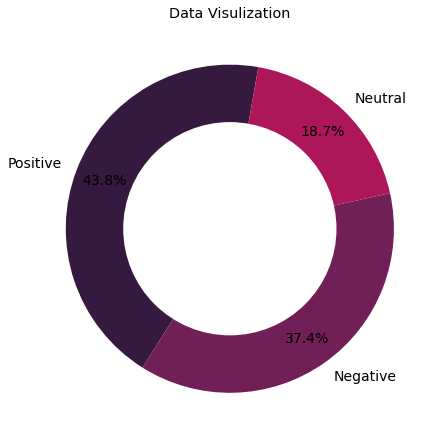

In [68]:
# plot of tweet sentiment distribution
plt.figure(figsize=(6,6))

sentiments = train.Sentiment.value_counts()

sns.set_palette("rocket")
plt.pie(sentiments,
        labels= sentiments.index,
        autopct='%1.1f%%', startangle=80, 
        pctdistance=0.82, textprops={"fontsize": 14})

centreCircle = plt.Circle((0,0),0.65,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centreCircle)

plt.tight_layout()
plt.title("Data Visulization")

plt.show()

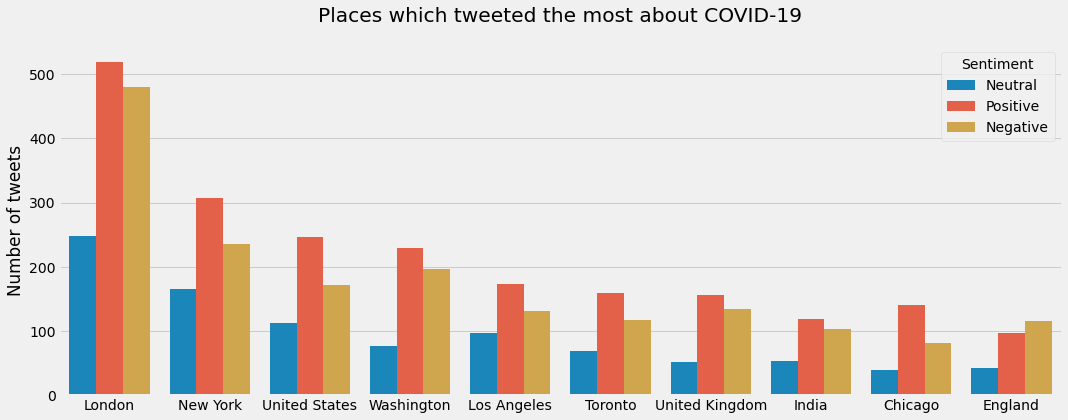

In [69]:
# plot of top cities/countries
plt.style.use("fivethirtyeight")

plt.figure(figsize=(16, 6))
location = sns.countplot(x= 'Location', data= train, hue="Sentiment", order=train.Location.value_counts()[:10].index)
location.set_title("Places which tweeted the most about COVID-19", y=1.05)

def axis_labels(ax):
    ax.set_ylabel("Number of tweets")
    ax.set_xlabel("")

axis_labels(location)

plt.show()

In [70]:
# Converting the TweetAt column to date time 
train['TweetAt'] = pd.to_datetime(train['TweetAt'])

# create day of the week and month columns
train['day'] = train['TweetAt'].dt.dayofweek
train['month'] = train['TweetAt'].dt.month

days = {0: 'Monday', 1: 'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
months = {0: 'January ', 1: 'February', 2:'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July',
      7:'August', 8:'September', 9: 'October', 10: 'November', 11: 'December'  }

train["day"] = train["day"].map(days)
train["month"] = train["month"].map(months)

In [71]:
print(f"First tweet: {train['TweetAt'].dt.date.min()}, Last tweet: {train['TweetAt'].dt.date.max()}")

First tweet: 2020-01-04, Last tweet: 2020-12-04


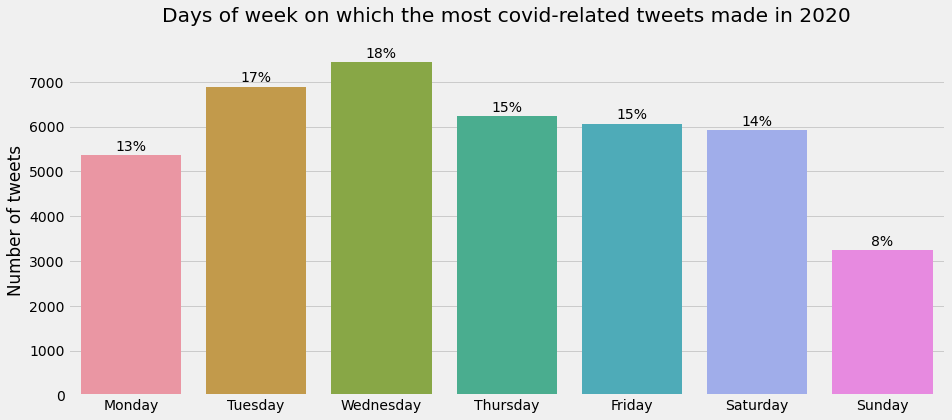

In [72]:
plt.figure(figsize=(14, 6))
days = sns.countplot(x="day", data=train)
days.set_title("Days of week on which the most covid-related tweets made in 2020", 
                                             y=1.05)

def add_labels(ax, space):
    for rect in ax.patches:
        width = rect.get_width()
        height = rect.get_height()
        total = train.shape[0]
        
        ax.text(rect.get_x() + width/2,
               height + space,
               '{}%'.format(int(np.round(height/total*100))),
                ha="center")

add_labels(days, 100)
axis_labels(days)
plt.show()

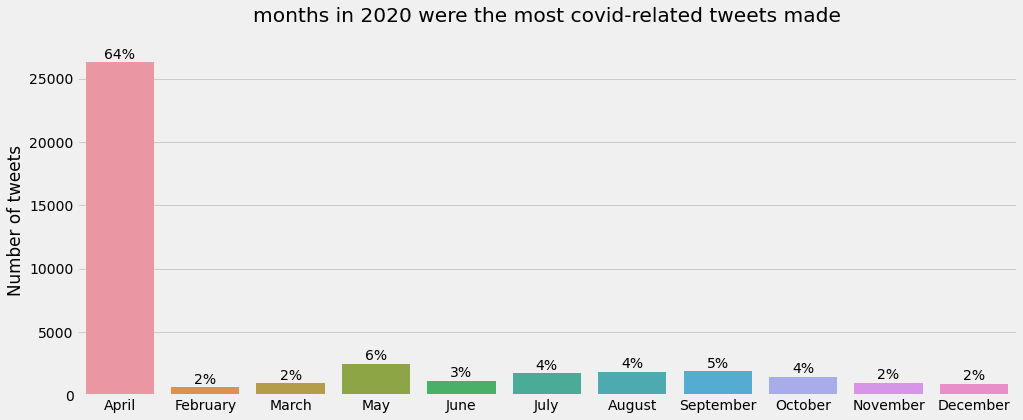

In [73]:
plt.figure(figsize=(15, 6))
months = sns.countplot(train['month'])
months.set_title("months in 2020 were the most covid-related tweets made", 
                                             y=1.05)

add_labels(months, 300)
axis_labels(months)
plt.show()

In [74]:
def tweets(df, n, col_name="OriginalTweet"):
    for tweet_no, tweet in enumerate(df[col_name][:n]):
        print(tweet_no+1, tweet, '\n')
        print("*" * 60, '\n')
        
tweets(train, 10)

1 @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8 

************************************************************ 

2 advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order 

************************************************************ 

3 Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P 

************************************************************ 

4 My food stock is not the only one which is empty...

PLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. 
Stay calm, stay safe.

#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j 

****************

In [75]:
# combine train and test dataframes
combined = pd.concat([train, test], ignore_index= True)

# select relevant features: tweet and Sentiments
combined = combined.loc[:, ["OriginalTweet", "Sentiment"]]

# load stop words
stop_word = stopwords.words('english')

def clean_tweet(text):
    text = re.sub(r"#\w+", " ", text)            # remove hashtags
    text = re.sub(r"@\w+", " ",text)             # remove mentions
    text = re.sub(r"http\S+", " ", text)         # remove urls
    text = re.sub(r"[^a-zA-Z]", " ", text)        # remove non-words (digits, punctuations etc)
    text = text.lower().strip()                  # convert tweet to lowercase and strip
    
    text = " ".join([word for word in text.split() if not word in stop_word])           # remove stop words    
    
    text = " ".join(nltk.word_tokenize(text))           # tokenize text
      
    return text

# clean OriginalTweet and assign the data to an new "tweet" column
combined['tweet'] = combined['OriginalTweet'].apply(lambda x: clean_tweet(x))

In [76]:
tweets(combined, 8, "tweet")

1  

************************************************************ 

2 advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order 

************************************************************ 

3 coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak 

************************************************************ 

4 food stock one empty please panic enough food everyone take need stay calm stay safe 

************************************************************ 

5 ready go supermarket outbreak paranoid food stock litteraly empty serious thing please panic causes shortage 

************************************************************ 

6 news region first confirmed covid case came sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper goods reports 

In [77]:
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image

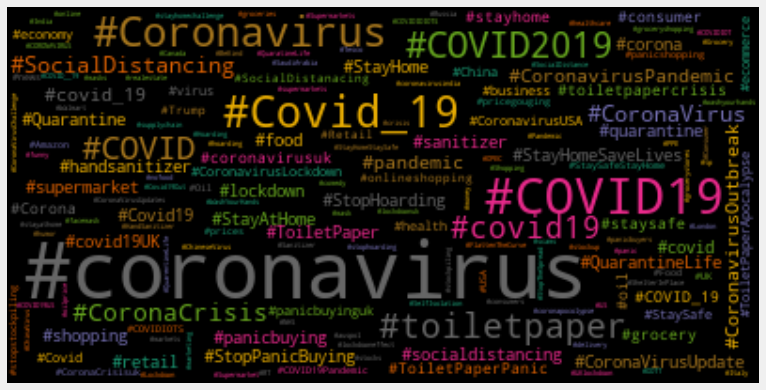

In [78]:
def create_wordCloud(pattern):
    """create word cloud visualization
    
    arguments:
        pattern (str): regex pattern to extract certain text from the data
    """
    data = train["OriginalTweet"].str.extractall(pattern)[0].value_counts()

    data.index = data.index.map(str)                                                       # convert data index to string
    data_wc = WordCloud(max_words = 500, colormap='Dark2_r', 
                        background_color='black').generate_from_frequencies(data)          # generate word cloud

    
    # display the cloud
    fig = plt.figure()
    fig.set_figwidth(12) # set width
    fig.set_figheight(12) # set height

    plt.imshow(data_wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
# create word cloud of the most frequently used hashtags
hashtag = r"(#\w+)"
create_wordCloud(hashtag)

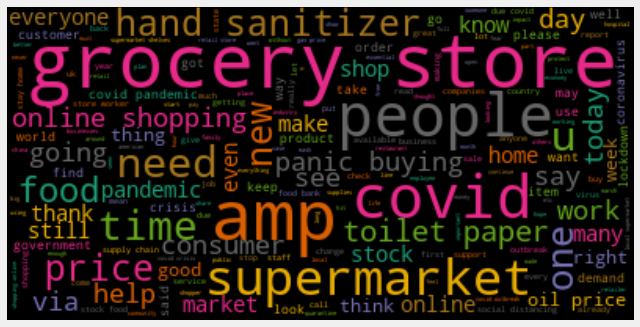

In [79]:
# most common words in our tweet data
corpus = ",".join(word for word in combined.tweet)
stopwords = set(STOPWORDS)
tweet_wc = WordCloud(max_words = 500, colormap='Dark2_r', 
                        background_color='black', stopwords=stopwords).generate(corpus)   

# display the cloud
fig = plt.figure()
fig.set_figwidth(10) # set width
fig.set_figheight(10) # set height

plt.imshow(tweet_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [80]:
# encode Sentiment label values
le = LabelEncoder()
combined.Sentiment = le.fit_transform(combined.Sentiment)

# split data back into training and validation sets and sets
train = combined[: len(train)]
test = combined[len(train):].reset_index(drop=True)

# split test test set
X_test = test.tweet
y_test = test.Sentiment


# split training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train.tweet,train.Sentiment, test_size=0.2,random_state=42)

In [81]:
# initialize vectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=5).fit(X_train)

X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [82]:
# intializing the model and fitting it on the training data
logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(X_train, y_train)

# checking training accuracy achieved
cross_val_score(logmodel, X_train, y_train, cv=5, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


0.7938648443432041

In [83]:
# extract labels from encoder
labels = list(le.classes_)
print(classification_report(val_pred, y_val, target_names= labels), '\n')



In [84]:
# make predictions
val_pred = logmodel.predict(X_val)
test_pred = logmodel.predict(X_test)

# print classification report
print(classification_report(test_pred, y_test, target_names= labels))

              precision    recall  f1-score   support

    Negative       0.79      0.82      0.80      2949
     Neutral       0.75      0.70      0.72      1677
    Positive       0.84      0.84      0.84      3606

    accuracy                           0.80      8232
   macro avg       0.79      0.78      0.79      8232
weighted avg       0.80      0.80      0.80      8232
 

              precision    recall  f1-score   support

    Negative       0.78      0.82      0.80      1542
     Neutral       0.69      0.66      0.68       648
    Positive       0.83      0.80      0.82      1608

    accuracy                           0.79      3798
   macro avg       0.77      0.76      0.76      3798
weighted avg       0.79      0.79      0.79      3798



In [85]:
# check test accuracy
print('accuracy score on validation set: ', accuracy_score(y_val, val_pred))
print('accuracy score on test set:', accuracy_score(y_test, test_pred))

accuracy score on validation set:  0.8029640427599611
accuracy score on test set: 0.7859399684044234


In [34]:
#implemnting solution using naive bayaes algorithm
from sklearn import naive_bayes
model=naive_bayes.MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [36]:
predNB=model.predict(X_test)

In [37]:
print(accuracy_score(y_test,predNB))

0.6808846761453397


In [38]:
print(classification_report(y_test,predNB,target_names= labels))

              precision    recall  f1-score   support

    Negative       0.70      0.74      0.72      1633
     Neutral       0.52      0.42      0.47       619
    Positive       0.71      0.72      0.72      1546

    accuracy                           0.68      3798
   macro avg       0.64      0.63      0.63      3798
weighted avg       0.68      0.68      0.68      3798



In [39]:
from sklearn.ensemble import RandomForestClassifier
RFC=RandomForestClassifier(random_state=0)
RFC.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [40]:
predrfc=RFC.predict(X_test)

In [45]:
print(accuracy_score(y_test,predrfc))

0.7317008952080042


In [46]:
print(classification_report(y_test,predrfc,target_names= labels))

              precision    recall  f1-score   support

    Negative       0.75      0.72      0.74      1633
     Neutral       0.61      0.67      0.64       619
    Positive       0.76      0.77      0.77      1546

    accuracy                           0.73      3798
   macro avg       0.71      0.72      0.71      3798
weighted avg       0.73      0.73      0.73      3798



In [47]:
from sklearn.tree import DecisionTreeClassifier
DTC=DecisionTreeClassifier(random_state=0)
DTC.fit(X_train,y_train)

DecisionTreeClassifier(random_state=0)

In [48]:
preddtc=DTC.predict(X_test)

In [49]:
print(accuracy_score(y_test,preddtc))

0.6532385466034755


In [50]:
pip install pad_sequences

  Using cached pad-sequences-0.6.1.tar.gz (9.5 kB)
  Created wheel for pad-sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10217 sha256=f6a3ddef59562eeee6ac9a1b1ad29ce7912ed34f233e41f95211d06b5afb0919
  Stored in directory: /Users/hunchoahmad/Library/Caches/pip/wheels/c4/d9/67/a54f34d9d990867c70393d7904a47df2f20f3712c1d246d5f5
Successfully built pad-sequences
Note: you may need to restart the kernel to use updated packages.


In [91]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM,GRU, Embedding, Dropout
from keras.layers import GlobalMaxPooling1D, Bidirectional
from keras.preprocessing.text import Tokenizer


model=Sequential()
model.add(Embedding(5000,256,input_length=X_train.shape[1])) #embedding layer 
model.add(Dropout(0.3))#dropout layrs
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [92]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 16047, 256)        1280000   
                                                                 
 dropout_1 (Dropout)         (None, 16047, 256)        0         
                                                                 
 lstm_3 (LSTM)               (None, 16047, 256)        525312    
                                                                 
 lstm_4 (LSTM)               (None, 16047, 256)        525312    
                                                                 
 lstm_5 (LSTM)               (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2,856,707
Trainable params: 2,856,707
No

In [53]:
y_train=pd.get_dummies(train['Sentiment']).values
y_test=pd.get_dummies(test['Sentiment']).values